# Regression: RVM vs SVM

### Synthetic example:  fitting sinc function

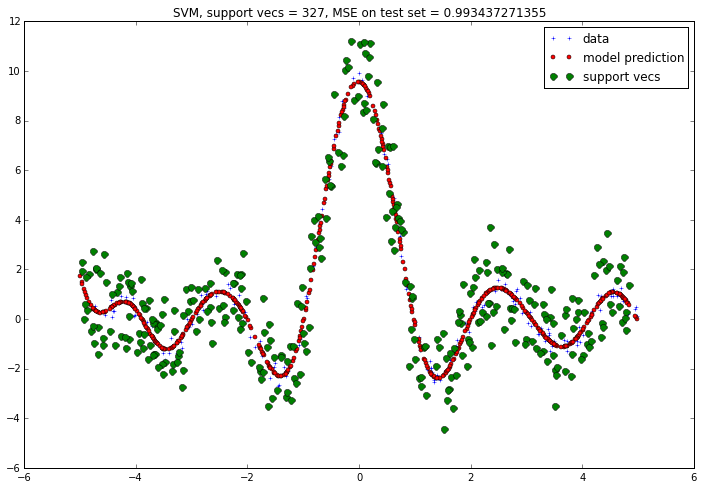

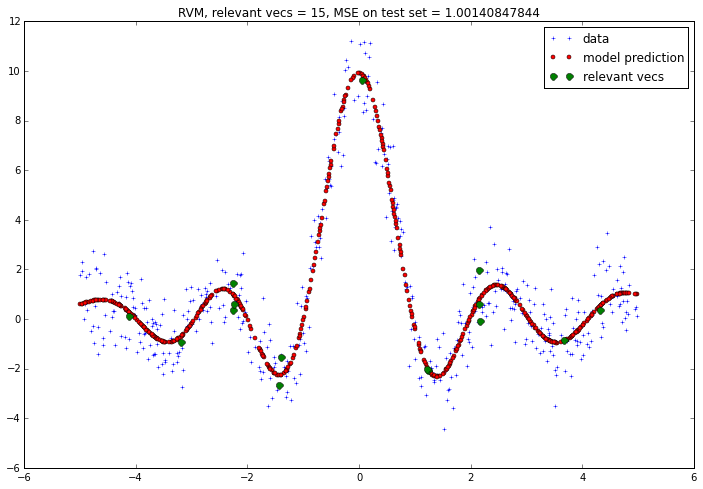

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from rvm import SparseBayesianLearner
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
%matplotlib inline


# parameters
n = 1000

# generate data set
np.random.seed(0)
Xc       = np.ones([n,1])
Xc[:,0]  = np.linspace(-5,5,n)
Yc       = 10*np.sinc(Xc[:,0]) + np.random.normal(0,1,n)
X,x,Y,y  = train_test_split(Xc,Yc,test_size = 0.5, random_state = 0)


# train rvm with fixed-point optimization
rvm = SparseBayesianLearner(learn_type = "regression", 
                            method     = "fixed-point",
                            alpha_max  = 10,
                            kernel     = "gaussian",
                            scaler     = 1)
rvm.fit(X,Y)

# training & cross validation of svr
svr = GridSearchCV(SVR(), param_grid = {"epsilon": np.logspace(-2,3,7), 
                                        "C":np.logspace(-3,3,7),
                                        "gamma": np.logspace(-2,2,5)})
svr.fit(X,Y)

# predict train set values with both models
y_svr = svr.predict(X)
y_rvm = rvm.predict(X)

# predict test set values
y_svr_test = svr.predict(x)
y_rvm_test = rvm.predict(x)

# plot data
model_names = ["SVM","RVM"]
models      = [y_svr,y_rvm]
models_test = [y_svr_test, y_rvm_test]


for model,model_name,model_test in zip(models, model_names, models_test):
    # plot data & predicted values
    plt.figure(figsize = (12,8))
    plt.plot(X[:,0],Y,"b+", markersize = 4, label = "data")
    plt.plot(X[:,0],model,"ro", markersize = 4, label = "model prediction")
    
    # plot support vectors
    x_rvsv = None
    y_rvsv = None
    rsvl   = None
    rvsv   = None
    if model_name == "SVM":
        sv_index   = svr.best_estimator_.support_
        y_rvsv  = Y[sv_index]
        x_rvsv  = X[sv_index,0]
        rsvl    = "support vecs"
        rvsv    = sv_index.shape[0]
    else:
        y_rvsv  = Y[rvm.active[1:]]
        x_rvsv  = X[rvm.active[1:],0]
        rsvl    = "relevant vecs"
        rvsv    = np.sum(rvm.active)
    plt.plot(x_rvsv,y_rvsv,"go", markersize = 7, label = rsvl)
    model_err = mean_squared_error(model_test,y)
    title = "{0}, {1} = {2}, MSE on test set = {3}".format(model_name,rsvl,
                                                           rvsv, model_err)
    plt.title(title)
    plt.legend()
    plt.show()
    
